In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,AdaBoostClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             auc,
                             roc_auc_score,
                             roc_curve,
                             f1_score,
                             recall_score,
                             precision_score,
                             classification_report)

## Default Model Training Functions

In [2]:
default_models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=0,n_jobs=-1),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0,n_jobs=-1),
    'LogisticRegression': LogisticRegression(random_state=0),
    'XGBClassifier': XGBClassifier(random_state=0),
    'SVM': svm.SVC(random_state=0),
    'Naive_Bayes': GaussianNB(),


}


In [3]:
def train_models(default_models, X_train, y_train):

    for name, model in default_models.items():
        model.fit(X_train, y_train)
    return default_models

## Hyperparameter tuning functions

In [4]:
models_hyp = {
    'RandomForestClassifier': RandomForestClassifier(random_state=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=0),
    'XGBClassifier' : XGBClassifier(random_state=0)

}

In [5]:
hyperparameters_grid = {
    'RandomForestClassifier': {
        'n_estimators': [100, 300, 400],
        'max_depth': [2, 4, 6, 10],
        'min_samples_split': [2, 4, 6, 8]
    },
    'ExtraTreesClassifier': {
        'n_estimators': [100, 300, 400],
        'max_depth': [2, 4, 6, 10],
        'min_samples_split': [2, 4, 6, 8]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 4, 6, 10],
        'min_samples_split': [2, 4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.05]
    },
    'XGBClassifier': {
        'n_estimators': [100, 300, 400],
        'max_depth': [2, 4, 6, 10],
        'learning_rate': [0.01, 0.1, 0.05]
    }
}


In [6]:
hyperparameters_random = {
    'RandomForestClassifier': {
        'n_estimators': list(np.linspace(start=100, stop=500, num=5).astype(int)),
        'max_depth': [None] + list(np.linspace(2, 12, num=6).astype(int)),
        'min_samples_split': list(np.linspace(2, 8, num=8).astype(int)),
        'min_samples_leaf': list(np.linspace(2, 8, num=8).astype(int)),
    },
    'ExtraTreesClassifier': {
        'n_estimators': list(np.linspace(start=100, stop=500, num=5).astype(int)),
        'max_depth': [None] + list(np.linspace(2, 12, num=6).astype(int)),
        'min_samples_split': list(np.linspace(2, 10, num=8).astype(int)),
        'min_samples_leaf': list(np.linspace(2, 10, num=8).astype(int)),
    },
    'GradientBoostingClassifier': {
        'n_estimators': list(np.linspace(start=100, stop=500, num=5).astype(int)),
        'learning_rate': [0.01, 0.1,0.001],
        'max_depth': list(np.linspace(2, 12, num=6).astype(int)),
        'min_samples_split': list(np.linspace(2, 10, num=8).astype(int)),
        'min_samples_leaf': list(np.linspace(2, 10, num=8).astype(int)),
        'max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    },
    'XGBClassifier': {
        'n_estimators': list(np.linspace(start=100, stop=500, num=5).astype(int)),
        'learning_rate': [0.01, 0.1,0.2],
        'max_depth': list(np.linspace(2, 12, num=6).astype(int)),
        'min_child_weight': list(np.linspace(1, 10, num=10).astype(int)),
        'gamma': [0, 0.1,0.2],
        'subsample': [0.5,0.8, 1.0],
        'colsample_bytree': [0.5,0.8, 1.0]
    }
}

In [3]:
def train_models_hyperparameter(models_hyp, hyperparameters, X_train, y_train,grid = False):
    tuned_models = {}
    best_params = {}
    for name, model in models_hyp.items():
        start_time = time.time()
        if grid == False:
          clf = RandomizedSearchCV(model, hyperparameters[name], cv=4,scoring = 'f1',n_jobs=-1)
          clf.fit(X_train, y_train)
          end_time = time.time()
          print(f"Training time for {name}: {end_time - start_time} seconds")
          tuned_models[name] = clf.best_estimator_
          best_params[name] = clf.best_params_
        else:
          clf = GridSearchCV(model, hyperparameters[name], cv=4,scoring = 'f1',n_jobs=-1)
          clf.fit(X_train, y_train)
          end_time = time.time()
          print(f"Training time for {name}: {end_time - start_time} seconds")
          tuned_models[name] = clf.best_estimator_
          best_params[name] = clf.best_params_

    return tuned_models,best_params


## Evaluation Function

In [37]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    model_names = []
    train_accuracy_scores = []
    test_accuracy_scores = []
    recall_scores = []
    roc_auc_scores = []
    precision_scores = []
    f1_scores = []
    confusion_matrices = {}
    roc_curves = {}
    classification_reports = {}

    for name, model in models.items():
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        confusion_matrices[name] = cm

        # Compute the classification report
        cr = classification_report(y_test, y_test_pred,output_dict=True)
        classification_reports[name] = cr

        # Compute the ROC AUC curve
        fpr, tpr, _ = roc_curve(y_test, y_test_pred)
        roc_auc = auc(fpr, tpr)
        roc_curves[name] = (fpr, tpr, roc_auc)

        model_names.append(name)
        train_accuracy_scores.append(accuracy_score(y_train, y_train_pred))
        test_accuracy_scores.append(accuracy_score(y_test, y_test_pred))
        recall_scores.append(recall_score(y_test, y_test_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_test_pred))
        precision_scores.append(precision_score(y_test, y_test_pred))
        f1_scores.append(f1_score(y_test, y_test_pred))

    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Model': model_names,
        'Train Accuracy': train_accuracy_scores,
        'Test Accuracy': test_accuracy_scores,
        'Recall': recall_scores,
        'ROC AUC': roc_auc_scores,
        'Precision': precision_scores,
        'F1 Score': f1_scores
    })

    return results_df, confusion_matrices, roc_curves, classification_reports


In [2]:
def plot_roc_curves(roc_curves):
    for name, (fpr, tpr, roc_auc) in roc_curves.items():
        plt.figure(figsize=(4,2))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {name}')
        plt.legend(loc="lower right")
        plt.show()


### This save function saves all results for default and hyperparameter tuned models.
* Set tuned to False if using default models

In [18]:
import os
from google.colab import files
import json


def save_evaluation_results(models, X_train, y_train, X_test, y_test, hyperparameters=None, best_params=None, tuned=False,grid=None):
    # Evaluate the models
    results_df, confusion_matrices, roc_curves, classification_reports = evaluate_models(models, X_train, y_train, X_test, y_test)

    # Define the prefix based on whether the model is tuned or not and gird search/random search
    prefix = 'Hyper_' if tuned else 'Default_'
    if grid is not None:
      prefix += 'Grid' if grid else 'Random'
    else:
      pass

    # Save the results dataframe
    results_df.to_csv(f'{prefix}_results.csv')

    # Save the confusion matrices, ROC curves, and classification reports
    for name, cm in confusion_matrices.items():
        os.makedirs(f'{prefix}_{name}', exist_ok=True)
        pd.DataFrame(cm).to_csv(f'{prefix}_{name}/{name}_confusion_matrix.csv')
        pd.DataFrame({
            'FPR': roc_curves[name][0],
            'TPR': roc_curves[name][1],
            'ROC_AUC': roc_curves[name][2]
        }).to_csv(f'{prefix}_{name}/{name}_roc_curve.csv')
        pd.DataFrame(classification_reports[name]).transpose().to_csv(f'{prefix}_{name}/{name}_classification_report.csv')

        # Zip the files and download
        !zip -r {prefix}_{name}.zip /content/{prefix}_{name}
        files.download(f'{prefix}_{name}.zip')

    # Save the hyperparameters and best parameters if the model is tuned
    if tuned:
        pd.DataFrame(hyperparameters).to_csv(f'{prefix}_hyperparameters.csv')
        !zip -r {prefix}_hyperparameters.zip /content/{prefix}_hyperparameters.csv
        files.download(f'{prefix}_hyperparameters.zip')

        pd.DataFrame(best_params).to_csv(f'{prefix}_best_params.txt')
        !zip -r {prefix}_best_params.zip /content/{prefix}_best_params.txt
        files.download(f'{prefix}_best_params.zip')


# ------------------------------------------------------------------------------------------------------------------------------

# Loading Dataset

In [8]:
X_train_smote_mi_og = pd.read_csv('/content/sample_data/X_train_smote_mi_og.csv')
y_train_smote_mi_og= pd.read_csv('/content/sample_data/y_train_smote_mi_og.csv')
X_test_mi_og= pd.read_csv('/content/sample_data/X_test_mi_og.csv')
y_test_mi_og= pd.read_csv('/content/sample_data/y_test_mi_og.csv')

In [ ]:
X_train_smote_mi_og.shape , X_test_mi_og.shape

((68004, 7), (10000, 7))

In [ ]:
X_train_smote_mi_og.head(2)

,route,booking_origin,flight_duration,trip_type_RoundTrip,length_of_stay,wants_extra_baggage,wants_in_flight_meals
0,2.296482,1.794457,-0.436058,1.0,-0.538770,0.0,1.0
1,-0.653994,0.754554,1.039153,1.0,-0.568591,1.0,0.0


# Default Model Training

In [ ]:
def_models = train_models(default_models, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'])

In [ ]:
def_report, def_cm,def_rocauc,def_classifreport = evaluate_models(def_models, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'])

In [ ]:
def_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.933636,0.7939,0.438514,0.647074,0.345396,0.386425
1,GradientBoostingClassifier,0.793762,0.7560,0.658108,0.715556,0.334938,0.443938
2,ExtraTreesClassifier,0.933636,0.7904,0.408108,0.632458,0.331140,0.365617
3,LogisticRegression,0.725119,0.7317,0.700000,0.718603,0.316336,0.435752
4,XGBClassifier,0.853700,0.7911,0.527703,0.682279,0.359742,0.427828
5,SVM,0.737001,0.6992,0.754054,0.721863,0.296809,0.425954
6,Naive_Bayes,0.711782,0.6232,0.819595,0.704340,0.257319,0.391669


## Saving default model reports

In [ ]:
save_evaluation_results(def_models, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'],tuned=False)

In [ ]:
for name in def_models.keys():
  !zip -r Default_{name}.zip /content/Default_{name}
  files.download(f'Default_{name}.zip')

  adding: content/Default_RandomForestClassifier/ (stored 0%)
  adding: content/Default_RandomForestClassifier/RandomForestClassifier_classification_report.csv (deflated 40%)
  adding: content/Default_RandomForestClassifier/RandomForestClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Default_RandomForestClassifier/RandomForestClassifier_roc_curve.csv (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Default_GradientBoostingClassifier/ (stored 0%)
  adding: content/Default_GradientBoostingClassifier/GradientBoostingClassifier_roc_curve.csv (deflated 42%)
  adding: content/Default_GradientBoostingClassifier/GradientBoostingClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Default_GradientBoostingClassifier/GradientBoostingClassifier_classification_report.csv (deflated 39%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Default_ExtraTreesClassifier/ (stored 0%)
  adding: content/Default_ExtraTreesClassifier/ExtraTreesClassifier_classification_report.csv (deflated 41%)
  adding: content/Default_ExtraTreesClassifier/ExtraTreesClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Default_ExtraTreesClassifier/ExtraTreesClassifier_roc_curve.csv (deflated 43%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Default_LogisticRegression/ (stored 0%)
  adding: content/Default_LogisticRegression/LogisticRegression_roc_curve.csv (deflated 40%)
  adding: content/Default_LogisticRegression/LogisticRegression_confusion_matrix.csv (stored 0%)
  adding: content/Default_LogisticRegression/LogisticRegression_classification_report.csv (deflated 38%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Default_XGBClassifier/ (stored 0%)
  adding: content/Default_XGBClassifier/XGBClassifier_classification_report.csv (deflated 40%)
  adding: content/Default_XGBClassifier/XGBClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Default_XGBClassifier/XGBClassifier_roc_curve.csv (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Default_SVM/ (stored 0%)
  adding: content/Default_SVM/SVM_roc_curve.csv (deflated 43%)
  adding: content/Default_SVM/SVM_classification_report.csv (deflated 42%)
  adding: content/Default_SVM/SVM_confusion_matrix.csv (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Default_Naive_Bayes/ (stored 0%)
  adding: content/Default_Naive_Bayes/Naive_Bayes_roc_curve.csv (deflated 41%)
  adding: content/Default_Naive_Bayes/Naive_Bayes_confusion_matrix.csv (stored 0%)
  adding: content/Default_Naive_Bayes/Naive_Bayes_classification_report.csv (deflated 40%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# We can try hyperparameter tuning to see if default model further improves

* __Grid search cv__

In [ ]:
trained_hyp_grid,best_params = train_models_hyperparameter(models_hyp, hyperparameters_grid, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'],grid=True)

Training time for RandomForestClassifier: 1177.0050461292267 seconds
Training time for ExtraTreesClassifier: 616.9066693782806 seconds
Training time for GradientBoosting: 9491.15435218811 seconds
Training time for XGBClassifier: 216.41284346580505 seconds


In [ ]:
Grid_hyp_report, Grid_hyp_cm,Grid_hyp_rocauc,Grid_hyp_classifreport = evaluate_models(trained_hyp_grid, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'])

In [ ]:
Grid_hyp_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.804306,0.7379,0.702703,0.723358,0.322881,0.442459
1,ExtraTreesClassifier,0.745103,0.7125,0.753378,0.729389,0.307586,0.436827
2,GradientBoosting,0.921784,0.8098,0.418243,0.648030,0.372892,0.394268
3,XGBClassifier,0.896727,0.7960,0.480405,0.665614,0.358729,0.410745


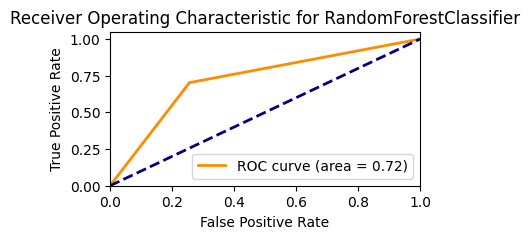

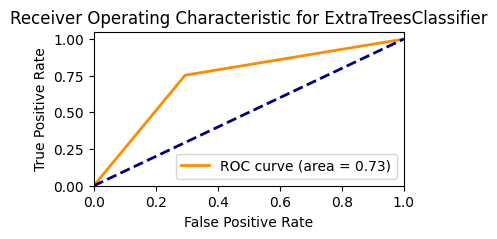

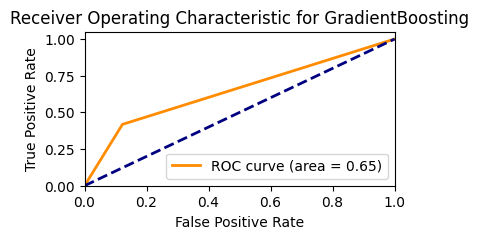

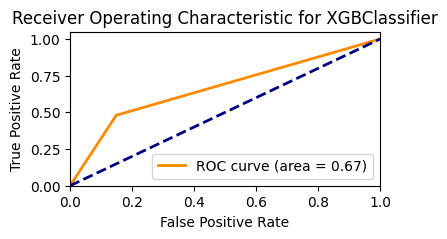

In [ ]:
plot_roc_curves(Grid_hyp_rocauc)

* __Random search cv__

In [ ]:
trained_hyp_random,best_params_random = train_models_hyperparameter_grid(models_hyp, hyperparameters_random, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'],grid=False)

Training time for RandomForestClassifier: 288.1799237728119 seconds
Training time for ExtraTreesClassifier: 152.61509585380554 seconds
Training time for GradientBoostingClassifier: 803.6802403926849 seconds
Training time for XGBClassifier: 112.13564777374268 seconds


In [ ]:
Random_hyp_report, Random_hyp_cm,Random_hyp_rocauc,Random_hyp_classifreport = evaluate_models(trained_hyp_random, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'])

In [ ]:
Random_hyp_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.800997,0.7380,0.702703,0.723417,0.322981,0.442553
1,ExtraTreesClassifier,0.747971,0.7157,0.746622,0.728475,0.309264,0.437364
2,GradientBoostingClassifier,0.883448,0.8074,0.468919,0.667558,0.378408,0.418829
3,XGBClassifier,0.907211,0.7877,0.453378,0.649577,0.338035,0.387302


In [ ]:
best_params_random

{'RandomForestClassifier': {'n_estimators': 300,
  'min_samples_split': 2,
  'min_samples_leaf': 3,
  'max_depth': 10},
 'ExtraTreesClassifier': {'n_estimators': 200,
  'min_samples_split': 8,
  'min_samples_leaf': 10,
  'max_depth': None},
 'GradientBoostingClassifier': {'n_estimators': 400,
  'min_samples_split': 6,
  'min_samples_leaf': 3,
  'max_features': 0.7,
  'max_depth': 6,
  'learning_rate': 0.1},
 'XGBClassifier': {'subsample': 0.5,
  'n_estimators': 500,
  'min_child_weight': 1,
  'max_depth': 10,
  'learning_rate': 0.1,
  'gamma': 0,
  'colsample_bytree': 1.0}}

## Saving Hyperparameter results as csv and downloading them to lcoal machine.
* Check save_evaluation_results function at the start of notebook

In [ ]:
save_evaluation_results(trained_hyp_random, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'],hyperparameters_random,best_params_random,tuned=True,grid=False)

  adding: content/Hyper_Random_RandomForestClassifier/ (stored 0%)
  adding: content/Hyper_Random_RandomForestClassifier/RandomForestClassifier_classification_report.csv (deflated 40%)
  adding: content/Hyper_Random_RandomForestClassifier/RandomForestClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Hyper_Random_RandomForestClassifier/RandomForestClassifier_roc_curve.csv (deflated 44%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Hyper_Random_ExtraTreesClassifier/ (stored 0%)
  adding: content/Hyper_Random_ExtraTreesClassifier/ExtraTreesClassifier_classification_report.csv (deflated 41%)
  adding: content/Hyper_Random_ExtraTreesClassifier/ExtraTreesClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Hyper_Random_ExtraTreesClassifier/ExtraTreesClassifier_roc_curve.csv (deflated 41%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Hyper_Random_GradientBoostingClassifier/ (stored 0%)
  adding: content/Hyper_Random_GradientBoostingClassifier/GradientBoostingClassifier_roc_curve.csv (deflated 42%)
  adding: content/Hyper_Random_GradientBoostingClassifier/GradientBoostingClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Hyper_Random_GradientBoostingClassifier/GradientBoostingClassifier_classification_report.csv (deflated 40%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Hyper_Random_XGBClassifier/ (stored 0%)
  adding: content/Hyper_Random_XGBClassifier/XGBClassifier_classification_report.csv (deflated 40%)
  adding: content/Hyper_Random_XGBClassifier/XGBClassifier_confusion_matrix.csv (stored 0%)
  adding: content/Hyper_Random_XGBClassifier/XGBClassifier_roc_curve.csv (deflated 43%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Hyper_Random_hyperparameters.csv (deflated 63%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Hyper_Random_best_params.csv (deflated 39%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
best_params_random_json ={'RandomForestClassifier': {'n_estimators': 300,
                      'min_samples_split': 2,
                      'min_samples_leaf': 3,
                      'max_depth': 10},
                    'ExtraTreesClassifier': {'n_estimators': 200,
                      'min_samples_split': 8,
                      'min_samples_leaf': 10,
                      'max_depth': None},
                    'GradientBoostingClassifier': {'n_estimators': 400,
                      'min_samples_split': 6,
                      'min_samples_leaf': 3,
                      'max_features': 0.7,
                      'max_depth': 6,
                      'learning_rate': 0.1},
                    'XGBClassifier': {'subsample': 0.5,
                      'n_estimators': 500,
                      'min_child_weight': 1,
                      'max_depth': 10,
                      'learning_rate': 0.1,
                      'gamma': 0,
                      'colsample_bytree': 1.0}
                      }

In [54]:
# To maintain float and integers values, convert it to json

In [53]:
import json

with open('best_params_random_json.json', 'w') as f:
    json.dump(best_params_random_json, f)

# Lets visualize default models and tuned models performances

In [ ]:
default_report = pd.read_csv('/content/Default_results.csv',index_col=0)
grid_report = pd.read_csv('/content/Hyper_results.csv',index_col=0)
random_report = pd.read_csv('/content/Hyper_Random_results.csv',index_col=0)

In [ ]:
# Get the list of models
models = default_report.iloc[[0,1,2,4]]['Model'].values.tolist()

# Select rows from the DataFrame where 'Model' is in the list of models
default_report = default_report[default_report['Model'].isin(models)]

In [ ]:
default_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.933636,0.7939,0.438514,0.647074,0.345396,0.386425
1,GradientBoostingClassifier,0.793762,0.7560,0.658108,0.715556,0.334938,0.443938
2,ExtraTreesClassifier,0.933636,0.7904,0.408108,0.632458,0.331140,0.365617
4,XGBClassifier,0.853700,0.7911,0.527703,0.682279,0.359742,0.427828


In [ ]:
grid_report.loc[2,'Model'] = 	'GradientBoostingClassifier'
grid_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.804306,0.7379,0.702703,0.723358,0.322881,0.442459
1,ExtraTreesClassifier,0.745103,0.7125,0.753378,0.729389,0.307586,0.436827
2,GradientBoostingClassifier,0.921784,0.8098,0.418243,0.648030,0.372892,0.394268
3,XGBClassifier,0.896727,0.7960,0.480405,0.665614,0.358729,0.410745


In [ ]:
random_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.800997,0.7380,0.702703,0.723417,0.322981,0.442553
1,ExtraTreesClassifier,0.747971,0.7157,0.746622,0.728475,0.309264,0.437364
2,GradientBoostingClassifier,0.883448,0.8074,0.468919,0.667558,0.378408,0.418829
3,XGBClassifier,0.907211,0.7877,0.453378,0.649577,0.338035,0.387302


# Lets compare other metrics for models and reports

In [ ]:
dataframes = [default_report, grid_report, random_report ]


titles = ['Default Models','GridSearchCV Models',"RandomizedsearchCV Models" ]

# Combine all dataframes into one with an additional column 'Report'
for i, df in enumerate(dataframes):
    df['Report'] = titles[i]
df_all = pd.concat(dataframes)



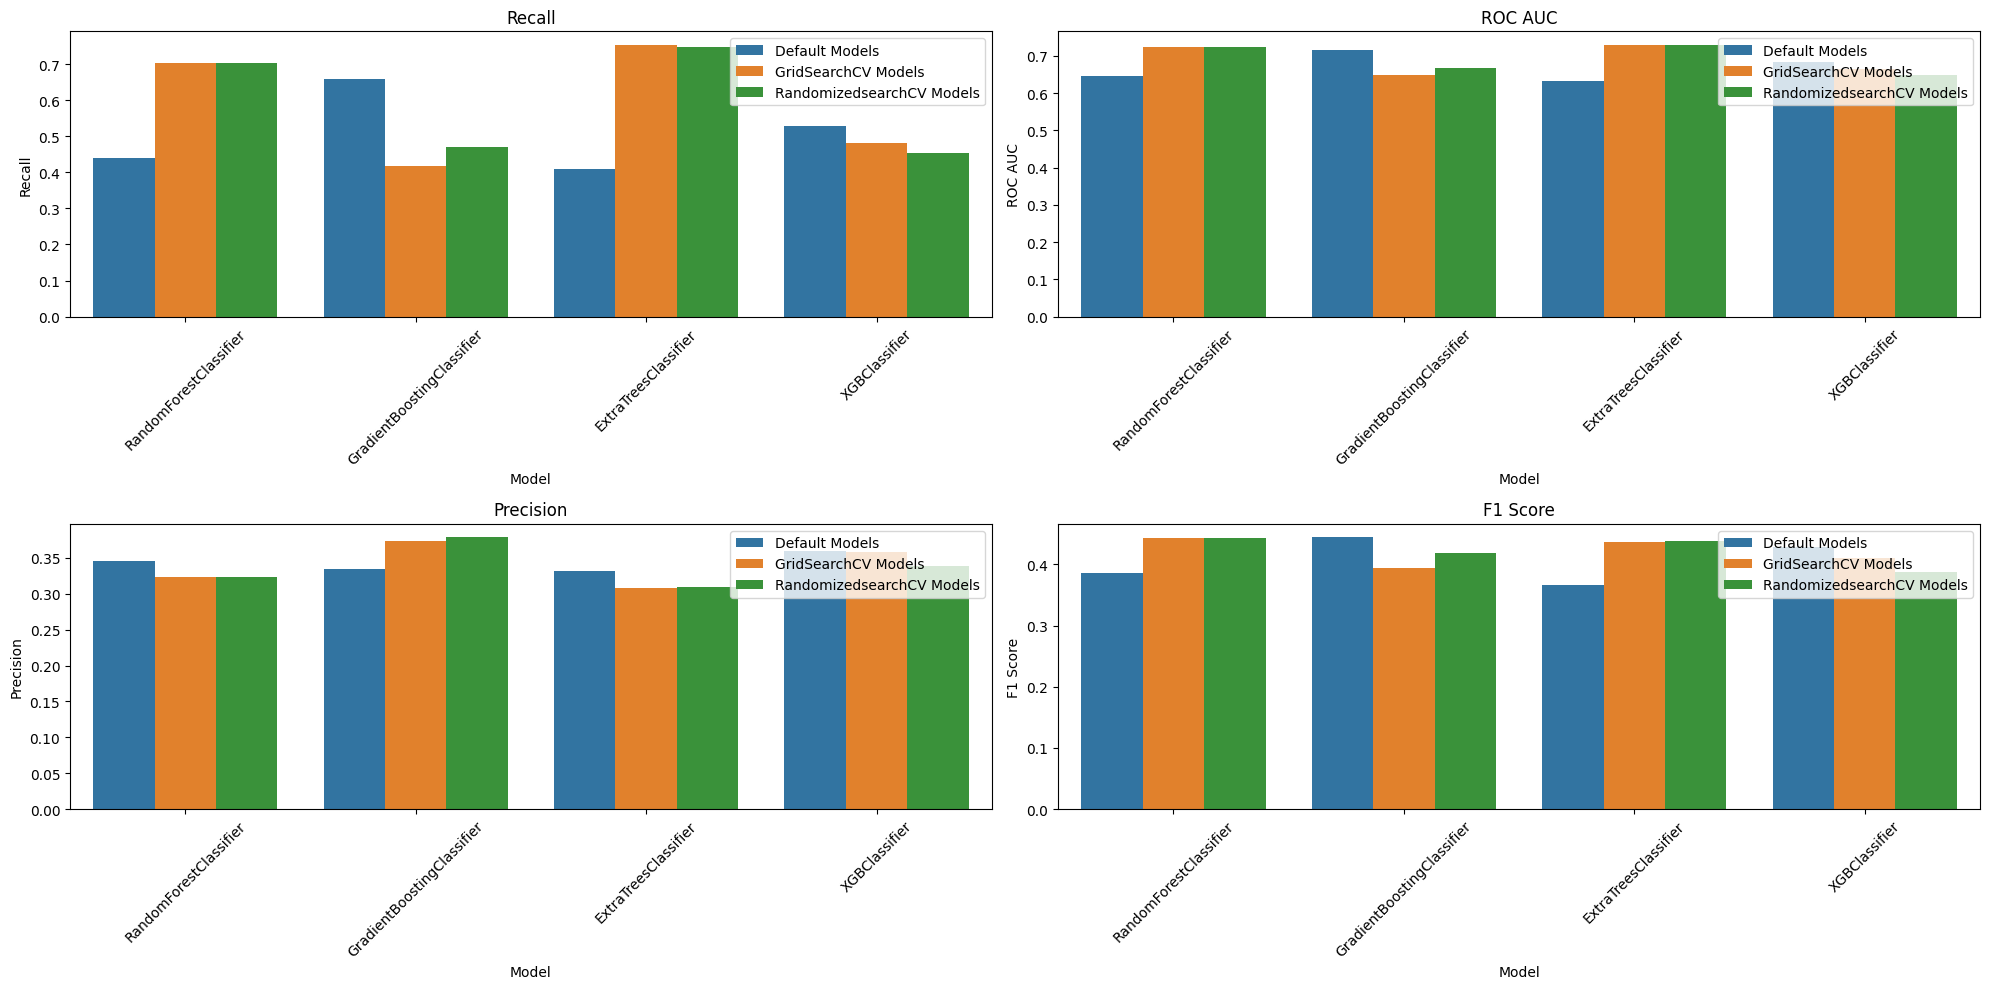

In [ ]:
plt.figure(figsize=(20,10))

# Creating sub-plots for each metric
metrics = ['Recall', 'ROC AUC', 'Precision', 'F1 Score']
n_rows = 2
n_cols = 2

for i, metric in enumerate(metrics):
    plt.subplot(n_rows, n_cols, i+1)
    sns.barplot(x='Model', y=metric, hue='Report', data=df_all)
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')  # Adjust the position of the legend

# Displaying the plots
plt.tight_layout()
plt.show()


### Insights:
* We can see that in RECALL, RF and Extra trees outperformed boosting models especially in tuned case.
* In ROC score, tuned RF and Extra trees did better.
* In precision, boosting models did better than RF and extra trees.
* In F1, tuned RF and Extra trees performed better.
* Default model of gradient boosting is doing well.

### Lets check overfitting

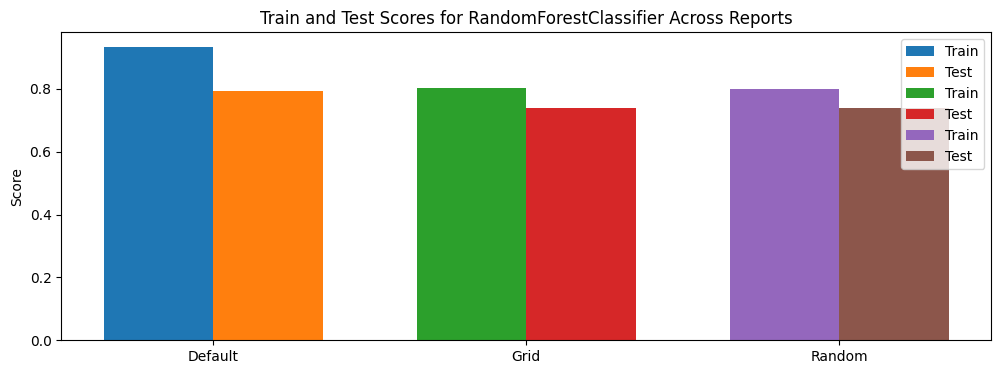

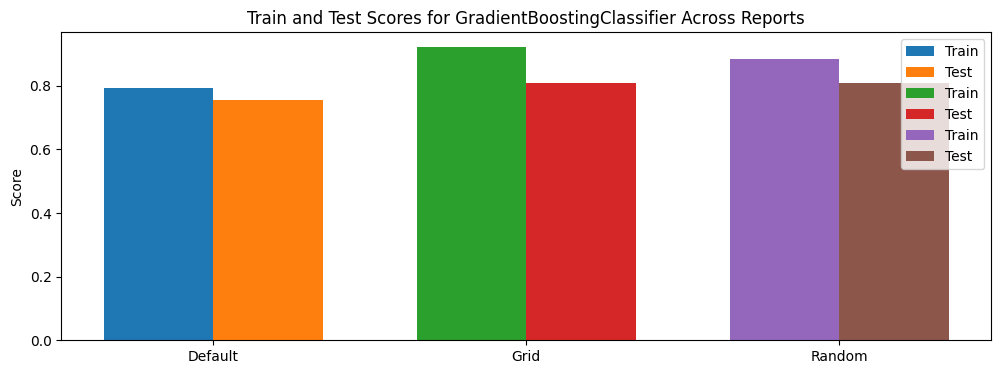

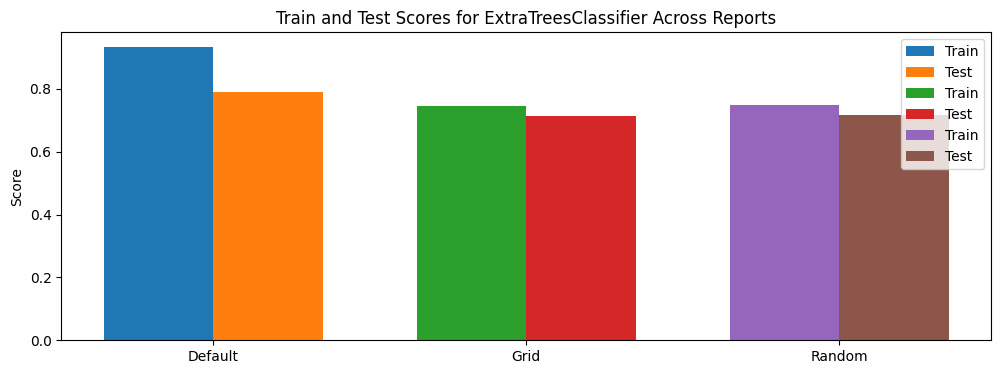

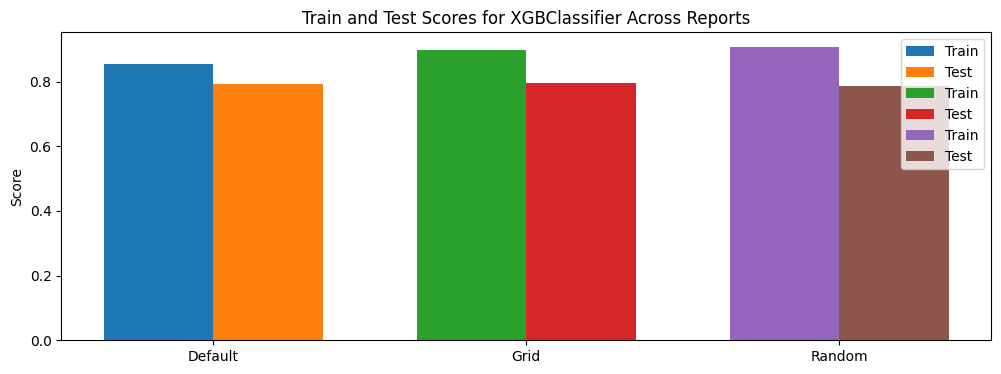

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframes are named default_report, grid_report, random_report
reports = [default_report, grid_report, random_report]
report_names = ['Default', 'Grid', 'Random']

models = default_report['Model'].unique()

for model in models:
    fig, ax = plt.subplots(figsize=(12,4))
    width = 0.35
    for i, report in enumerate(reports):
        model_data = report[report['Model'] == model]
        ax.bar(i - width/2, model_data['Train Accuracy'].mean(), width, label='Train')
        ax.bar(i + width/2, model_data['Test Accuracy'].mean(), width, label='Test')


    ax.set_ylabel('Score')
    ax.set_title(f'Train and Test Scores for {model} Across Reports')
    ax.set_xticks(range(len(report_names)))
    ax.set_xticklabels(report_names)
    ax.legend()

plt.show()


* __We can see that there is overfitting across all reports. Random Forest and Extratrees have minimal overfitting for hyperparameter tuned reports. On the contrary, GB and XGB have minimal overfitting for default and considerable for tuned reports__

# __--------------------------------------------------------------------------------------__

## Overall Insight:
* For hyperparameter tuned reports, Rf and Extra trees perform better and compared to the level of overfitting in default models, tuned models reduced the overfitting.
* For default models, Gradient Boosting does well

## We can consider  tuned RF or Extraa trees or default gradient Boosting. Since tuned models have been trained on multiple validation sets, it is more generalized than default models. So we will move ahead with RF and Extra trees.

## We can further try more tuning for RF and Extra trees.

In [25]:
models_hyp_fine = {
    'RandomForestClassifier': RandomForestClassifier(random_state=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=0),

}

In [10]:
fine_hyperparameters_grid_ = {
    'RandomForestClassifier': {
        'n_estimators': [50,100,150,200],
        'max_depth':  [2,3,6,10],
        'min_samples_split': [2,4,8],
        'min_samples_leaf': [2,4,8],
    },
    'ExtraTreesClassifier': {
        'n_estimators': [50,100,150,200],
        'max_depth':  [2,3,4,10],
        'min_samples_split': [2,4,8],
        'min_samples_leaf': [2,4,8],
    },

}

In [11]:
np.linspace(2, 16, num=15)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16.])

In [12]:
fine_hyperparameters_random_ = {
    'RandomForestClassifier': {
        'n_estimators': list(np.linspace(start=50, stop=250, num=5).astype(int)),
        'max_depth':  list(np.linspace(2, 8, num=4).astype(int)),
        'min_samples_split': list(np.linspace(2,7, num=6).astype(int)),
        'min_samples_leaf': list(np.linspace(2, 7, num=6).astype(int)),
    },
    'ExtraTreesClassifier': {
        'n_estimators': list(np.linspace(start=50, stop=250, num=5).astype(int)),
        'max_depth':  list(np.linspace(2, 8, num=4).astype(int)),
        'min_samples_split': list(np.linspace(2,7, num=6).astype(int)),
        'min_samples_leaf': list(np.linspace(2, 7, num=6).astype(int)),
    },

}

In [13]:
fine_hyp_random, fine_best_params_random = train_models_hyperparameter(models_hyp_fine, fine_hyperparameters_random_, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'],grid=False)

Training time for RandomForestClassifier: 122.75595140457153 seconds
Training time for ExtraTreesClassifier: 55.12382960319519 seconds


In [14]:
fine_Random_hyp_report, fine_Random_hyp_cm, fine_Random_hyp_rocauc, fine_Random_hyp_classifreport = evaluate_models(fine_hyp_random, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'])

In [15]:
fine_Random_hyp_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.775851,0.7238,0.725000,0.724296,0.313011,0.437245
1,ExtraTreesClassifier,0.736530,0.7096,0.749324,0.726012,0.304503,0.433034


In [322]:
fine_best_params_random

{'RandomForestClassifier': {'n_estimators': 150,
  'min_samples_split': 7,
  'min_samples_leaf': 6,
  'max_depth': 8},
 'ExtraTreesClassifier': {'n_estimators': 100,
  'min_samples_split': 6,
  'min_samples_leaf': 3,
  'max_depth': 8}}

In [19]:
save_evaluation_results(fine_hyp_random, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'],fine_hyperparameters_random_,fine_best_params_random,tuned=True,grid=False)

updating: content/Hyper_Random_RandomForestClassifier/ (stored 0%)
updating: content/Hyper_Random_RandomForestClassifier/RandomForestClassifier_confusion_matrix.csv (stored 0%)
updating: content/Hyper_Random_RandomForestClassifier/RandomForestClassifier_classification_report.csv (deflated 39%)
updating: content/Hyper_Random_RandomForestClassifier/RandomForestClassifier_roc_curve.csv (deflated 40%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/Hyper_Random_ExtraTreesClassifier/ (stored 0%)
updating: content/Hyper_Random_ExtraTreesClassifier/ExtraTreesClassifier_confusion_matrix.csv (stored 0%)
updating: content/Hyper_Random_ExtraTreesClassifier/ExtraTreesClassifier_classification_report.csv (deflated 39%)
updating: content/Hyper_Random_ExtraTreesClassifier/ExtraTreesClassifier_roc_curve.csv (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/Hyper_Random_hyperparameters.csv (deflated 50%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/Hyper_Random_best_params.txt (deflated 21%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

* __Fine grid results__

In [ ]:
fine_hyp_grid, fine_best_params_grid = train_models_hyperparameter(models_hyp_fine,fine_hyperparameters_grid_, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'],grid=True)

Training time for RandomForestClassifier: 190.7389953136444 seconds
Training time for ExtraTreesClassifier: 81.8560721874237 seconds


In [ ]:
fine_grid_hyp_report, fine_grid_hyp_cm, fine_grid_hyp_rocauc, fine_grid_hyp_classifreport = evaluate_models(fine_hyp_grid, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'])

In [167]:
fine_grid_hyp_report

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,RandomForestClassifier,0.800629,0.7370,0.706757,0.724505,0.322640,0.443033
1,ExtraTreesClassifier,0.744044,0.7085,0.752703,0.726762,0.304122,0.433210


In [191]:
fine_best_grid = fine_best_params_grid
fine_best_grid

{'RandomForestClassifier': {'max_depth': 10,
  'min_samples_leaf': 2,
  'min_samples_split': 8,
  'n_estimators': 200},
 'ExtraTreesClassifier': {'max_depth': 10,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 200}}

In [173]:
save_evaluation_results(fine_hyp_grid, X_train_smote_mi_og, y_train_smote_mi_og['booking_complete'], X_test_mi_og, y_test_mi_og['booking_complete'],fine_hyperparameters_grid_,fine_best_params_grid,tuned=True,grid=True)

updating: content/Hyper_Grid_RandomForestClassifier/ (stored 0%)
updating: content/Hyper_Grid_RandomForestClassifier/RandomForestClassifier_classification_report.csv (deflated 40%)
updating: content/Hyper_Grid_RandomForestClassifier/RandomForestClassifier_confusion_matrix.csv (stored 0%)
updating: content/Hyper_Grid_RandomForestClassifier/RandomForestClassifier_roc_curve.csv (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/Hyper_Grid_ExtraTreesClassifier/ (stored 0%)
updating: content/Hyper_Grid_ExtraTreesClassifier/ExtraTreesClassifier_classification_report.csv (deflated 41%)
updating: content/Hyper_Grid_ExtraTreesClassifier/ExtraTreesClassifier_confusion_matrix.csv (stored 0%)
updating: content/Hyper_Grid_ExtraTreesClassifier/ExtraTreesClassifier_roc_curve.csv (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/Hyper_Grid_hyperparameters.csv (deflated 43%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: content/Hyper_Grid_best_params.json (deflated 50%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# The best model for is after hyperparameter tuning is Extratrees

# __--------------------------------------------------------------------------------------__

## Forgot to save pickle file for fitted model. We will load saved json file of hyperparameters and then save it as pickle.!!

In [15]:
X_train = pd.read_csv('../DATASETS/OG_MI_Smote/X_train_smote_mi_og.csv')
y_train = pd.read_csv('../DATASETS/OG_MI_Smote/y_train_smote_mi_og.csv')

In [18]:
X_test = pd.read_csv('../DATASETS/OG_MI_Smote/X_test_mi_og.csv')
y_test = pd.read_csv('../DATASETS/OG_MI_Smote/y_test_mi_og.csv')

In [19]:
Et = ExtraTreesClassifier(random_state=0)


In [29]:
f = open('../REPORTS/Hyper_parameter_tune/Grid/Tuned/Hyper_Grid_best_params.json')

In [30]:
import json
params = json.load(f)

In [33]:
Extratree_params = params['ExtraTreesClassifier']

In [35]:
Et.set_params(**Extratree_params)

ExtraTreesClassifier(max_depth=10, min_samples_leaf=2, n_estimators=200,
                     random_state=0)

In [36]:
Et.fit(X_train,y_train['booking_complete'])

ExtraTreesClassifier(max_depth=10, min_samples_leaf=2, n_estimators=200,
                     random_state=0)

In [41]:
import joblib

In [42]:

joblib.dump(Et,"Extratrees_final_model.pkl")

['Extratrees_final_model.pkl']

In [44]:
model = joblib.load("Extratrees_final_model.pkl")

In [47]:
models_dict = {'ExtraTreesClassifier': model}

In [48]:
results_df, confusion_matrices, roc_curves, classification_reports = evaluate_models(models_dict, X_train, y_train['booking_complete'], X_test, y_test['booking_complete'])

In [49]:
results_df

,Model,Train Accuracy,Test Accuracy,Recall,ROC AUC,Precision,F1 Score
0,ExtraTreesClassifier,0.744044,0.7085,0.752703,0.726762,0.304122,0.43321


## ROC curve

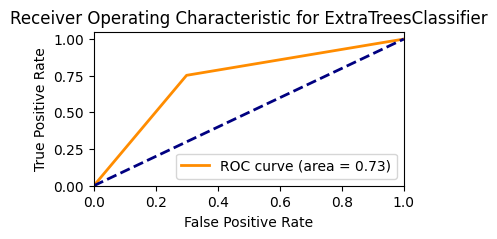

In [50]:
plot_roc_curves(roc_curves)

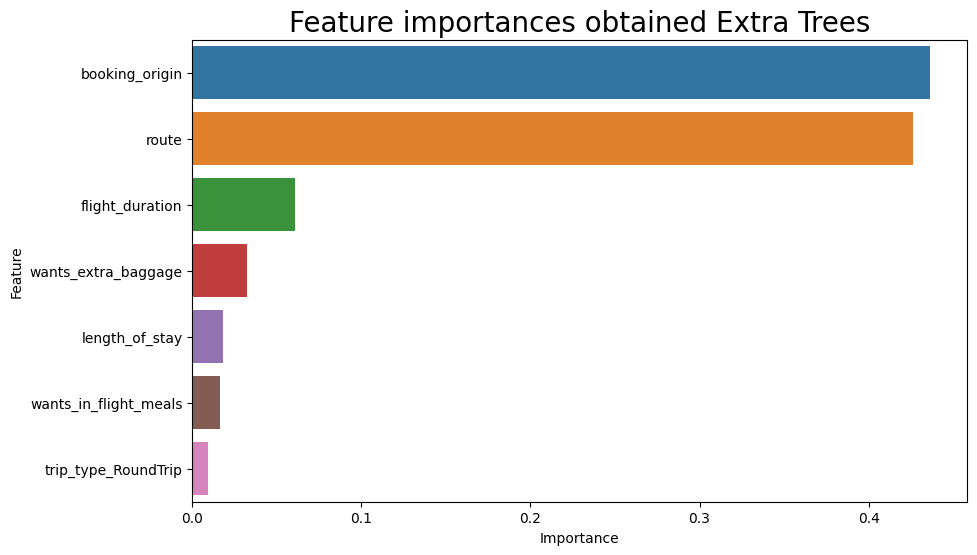

In [53]:
importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature importances obtained Extra Trees', size=20)
plt.show()

# Things to try :
* Dropping route and booking origin and check

In [22]:
df_classrep = pd.read_csv('FInal_report_gridcv\Hyper_Grid_ExtraTreesClassifier\ExtraTreesClassifier_classification_report.csv')

df_confmatrix = pd.read_csv('FInal_report_gridcv\Hyper_Grid_ExtraTreesClassifier\ExtraTreesClassifier_confusion_matrix.csv',index_col=0)

df_roc = pd.read_csv('FInal_report_gridcv\Hyper_Grid_ExtraTreesClassifier\ExtraTreesClassifier_roc_curve.csv')

## Calssification Report

In [23]:
df_classrep

,Unnamed: 0,precision,recall,f1-score,support
0,0,0.942244,0.700822,0.803796,8520.0000
1,1,0.304122,0.752703,0.433210,1480.0000
2,accuracy,0.708500,0.708500,0.708500,0.7085
3,macro avg,0.623183,0.726762,0.618503,10000.0000
4,weighted avg,0.847802,0.708500,0.748949,10000.0000


## Confusion Matrix

<AxesSubplot: >

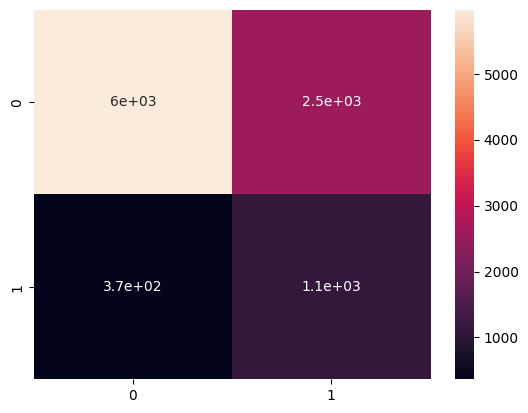

In [28]:
sns.heatmap(df_confmatrix,annot=True)